### Import libraries

In [77]:
import copy
import random

from pathlib import Path

import numpy as np
import pandas as pd

import networkx as nx

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout, Sigmoid

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.io import fs

from torch_geometric.nn import GCNConv, GINConv, GATv2Conv, GraphConv
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool

from scipy.sparse import coo_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Fix Seeds

In [78]:
seed = 42
random.seed(seed)   
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')  

DIR_PATH = Path.cwd().parent
DATA_BASE = DIR_PATH / 'data/converted/'
BALANCED_PATH = DATA_BASE / 'balanced'
UNBALANCED_PATH = DATA_BASE / 'unbalanced'

Device: cuda


### Read the data

In [80]:
def load_data(path: Path):
    """Load adjacency matrices from .npy file and data from .csv file
    Args:
        path (str): path to the folder containing adjacency matrices and data
    Returns:
        adj_matrices (np.ndarray): loaded adjacency matrices
        data (pd.DataFrame): loaded data
    """
    # Load adjacency matrices
    A = np.load(f'{path}/Adj_mtrx.npy')
    
    # Load data
    data = pd.read_csv(f'{path}/data.csv')
    
    # Convert data to numpy array
    return A, data

In [81]:
# load the adjacency matrices and the data
A, data = load_data(BALANCED_PATH)  

# Print information about the dataset
S, N = A.shape[0], A.shape[1]
print(f'Number of graphs: {S}')
print(f'Number of nodes: {N}')
display(data.head(5))

# store features in x (S, N, M) and labels in y (S, 1) 
x, y = np.expand_dims(data.iloc[:, 3:].values, axis=-1), np.expand_dims(data.iloc[:,2].values, axis=-1)
M = x.shape[-1]
print(f'Number of features per node: {M}')

Number of graphs: 500
Number of nodes: 20


,pat_id,conf,class,Prot1,Prot2,Prot3,Prot4,Prot5,Prot6,Prot7,...,Prot11,Prot12,Prot13,Prot14,Prot15,Prot16,Prot17,Prot18,Prot19,Prot20
0,1,0.165192,0,-0.288741,1.320418,1.246890,-0.587912,0.425350,1.433823,1.573993,...,1.338356,0.151599,1.333244,-0.893175,-0.736581,2.830105,-0.793974,-1.773393,2.129005,-0.543475
1,2,-0.513246,1,-0.973010,-0.083804,0.434048,1.785993,-1.266904,2.235005,0.844811,...,1.813073,0.427323,0.572022,0.844917,-1.381314,2.000934,0.857619,-4.184703,0.913778,-1.655555
2,3,-0.374802,1,-1.825425,1.211511,2.546314,0.161956,0.211815,4.396854,3.311472,...,-0.204465,-0.150981,1.128062,-0.049212,0.592243,-0.475274,-0.234234,-3.083168,3.457820,-1.471739
3,4,0.367808,1,0.449866,-0.493820,0.975631,1.253092,-1.101147,0.124996,1.165723,...,1.835069,-0.124808,1.011982,-0.066768,0.606598,4.985515,-0.124784,-1.378635,-0.934949,-1.366920
4,5,0.364785,1,-2.554269,-1.272309,0.446490,-1.364757,-0.525800,2.681961,0.755660,...,0.654083,-1.208418,1.341746,0.965073,0.798658,0.568156,2.077395,-2.634093,0.937716,0.327697


Number of features per node: 1


### EDA

In [82]:
def get_avg_degree_centrality(A: np.array) -> np.float64:
  """
    Calculate the average degree centrality of an adjacency matrix.
  """
  return np.mean(list(dict(nx.degree_centrality(nx.from_numpy_array(A))).values()))

def get_avg_closeness_centrality(A: np.array) -> np.float64:
  """
    Calculate the average closeness centrality of an adjacency matrix.
  """
  return np.mean(list(dict(nx.closeness_centrality(nx.from_numpy_array(A))).values()))

def get_avg_betweenness_centrality(A: np.array) -> np.float64:
  """
    Calculate the average betweenness centrality of an adjacency matrix.
  """
  return np.mean(list(dict(nx.betweenness_centrality(nx.from_numpy_array(A))).values()))

In [7]:
def histogram_classes(positive, negative, metric, ax, **kwargs):
    # Plot the histogram for positive and negative degrees
    sns.set(style="whitegrid")
    plt.figure(figsize=(5, 5))
    sns.histplot(positive, color="skyblue", label="Positive", ax=ax, **kwargs)
    sns.histplot(negative, color="salmon", label="Negative", ax=ax, **kwargs)
    ax.set_title(f"Average {metric}")
    ax.set_xlabel(f"Average {metric}")
    ax.set_ylabel("Frequency")
    ax.grid(linestyle=':')
    ax.legend()

All connected: True


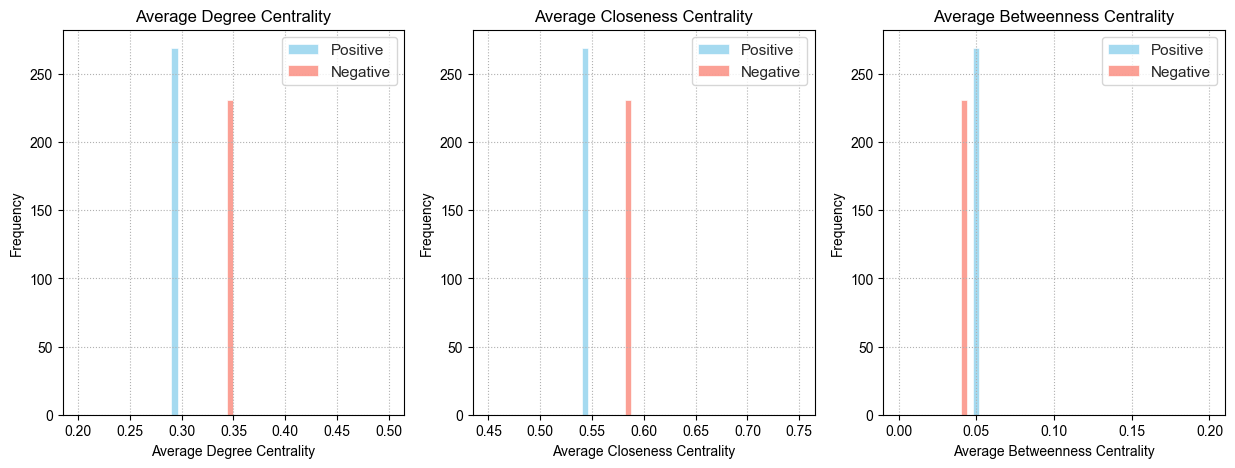

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [8]:
# Check if every graph is connected
print(f'All connected: {all(nx.is_connected(nx.from_numpy_array(G)) for G in A)}')

# Store the adjacency matrices for each of the classes
A_pos = A[np.where(y==0)[0]]
A_neg = A[np.where(y==1)[0]]

# Compute average degree centrality for each sample per class
deg_pos_mean = [get_avg_degree_centrality(a) for a in A_pos]
deg_neg_mean = [get_avg_degree_centrality(a) for a in A_neg]

# Compute average closeness centrality for each sample per class
cls_pos_mean = [get_avg_closeness_centrality(a) for a in A_pos]
cls_neg_mean = [get_avg_closeness_centrality(a) for a in A_neg]

# Compute average betweenness centrality for each sample per class
btw_pos_mean = [get_avg_betweenness_centrality(a) for a in A_pos]
btw_neg_mean = [get_avg_betweenness_centrality(a) for a in A_neg]


# Combine data and metrics into lists
pos_data = [deg_pos_mean, cls_pos_mean, btw_pos_mean]
neg_data = [deg_neg_mean, cls_neg_mean, btw_neg_mean]
metrics = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']
binranges = [(0.2, 0.5), (0.45, 0.75), (0, 0.2)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Iterate over the data and metrics to create each subplot
for i, (pos, neg, metric, binrange) in enumerate(zip(pos_data, neg_data, metrics, binranges)):
        histogram_classes(pos, neg, metric, ax=axes[i], bins=50, binrange=binrange)  
plt.tight_layout()
plt.show()

Apparently, we can already differentiate between positive and negative based on just the graph structure. **A perfect classifier just using a threshold**, do we even need any GNNs after this? We will further analyze the node features to see if there is a similar way to distinguish between the classes and apply some SOTA GNN models.

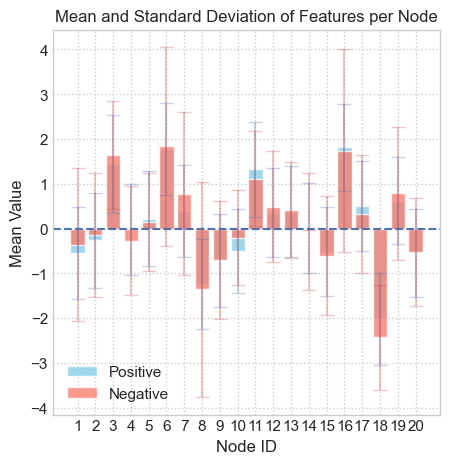

In [9]:
# plot the bars of mean and with std values

x_pos = x[np.where(y==0)[0]]
x_pos_mean = x_pos.mean(axis=0).squeeze()
x_pos_std = x_pos.std(axis=0).squeeze()

x_neg = x[np.where(y==1)[0]]
x_neg_mean = x_neg.mean(axis=0).squeeze()
x_neg_std = x_neg.std(axis=0).squeeze()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(5, 5))
plt.bar(range(1, x_pos_mean.shape[0]+1), x_pos_mean, color='skyblue', alpha=0.8, label='Positive', 
        yerr=x_pos_std, error_kw={'alpha': 0.3, 'capsize': 5, 'ecolor': 'b'})
plt.bar(range(1, x_neg_mean.shape[0]+1), x_neg_mean, color='salmon', alpha=0.8, label='Negative',
        yerr=x_neg_std, error_kw={'alpha': 0.3, 'capsize': 5, 'ecolor': 'r'})
plt.axhline(y=0, color='b', linestyle='--')
plt.xticks(range(1, x_pos_mean.shape[0]+1))
plt.grid(linestyle=':')
plt.title('Mean and Standard Deviation of Features per Node')
plt.xlabel('Node ID')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

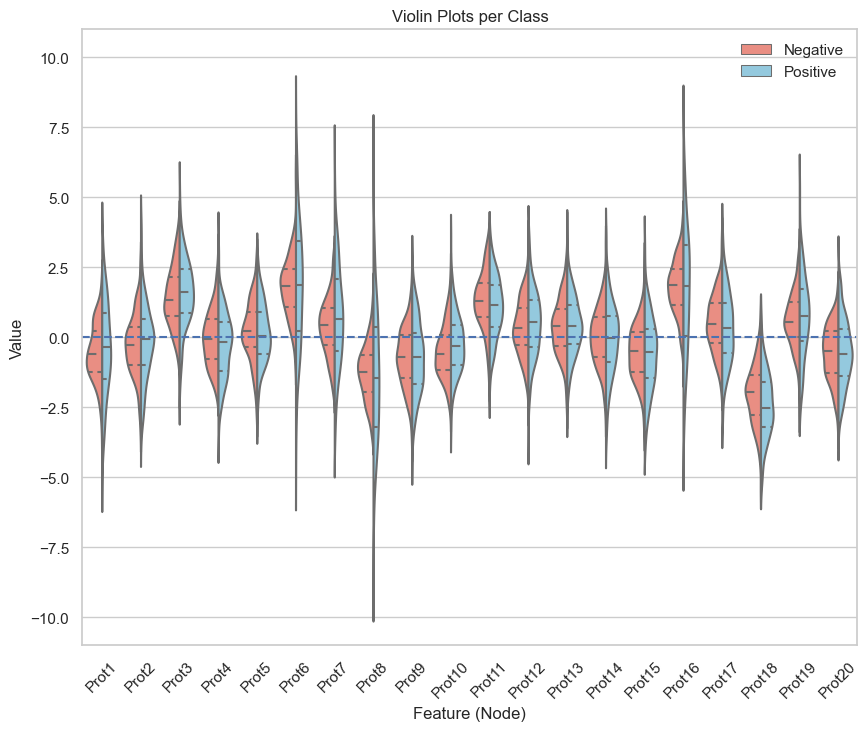

In [10]:
# Plot the violin plot of the features
df_melted = pd.melt(data, id_vars=['class'], 
                    value_vars=[f'Prot{i}' for i in range(1, 21)], 
                    var_name='Protein', value_name='Expression')
                                                                                                                                                                                                                                                                                                                                                                                                   
sns.set(style="whitegrid")
palette = {1: 'skyblue', 0: 'salmon'}
plt.figure(figsize=(10, 8))
ax = sns.violinplot(x='Protein', y='Expression', hue='class', data=df_melted, split=True, inner="quart", palette=palette)
ax.legend(handles=ax.legend_.legendHandles, labels=['Negative', 'Positive'])
plt.axhline(y=0, color='b', linestyle='--')
plt.title('Violin Plots per Class')
plt.xlabel('Feature (Node)')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.ylim([-11, 11])
plt.show()

<AxesSubplot: >

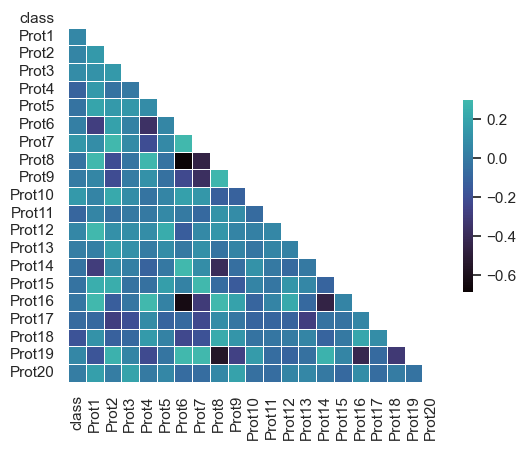

In [11]:
# Plot the correlation between the features
corr = data.iloc[:, 2:].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(6, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, vmax=.3, center=0, cmap='mako',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The features seem to have a Gaussian distribution. They do not provide a strong correlation with the **class** target, although some features, such as **Prot18**, **Prot11** seem to be more correlated, which is confirmed by the violin plats, which show a small difference in the mean values per class.

In [83]:
# Normalize the adjacency matrices
A_flat = A.flatten()
A_max, A_min = A_flat.max(), A_flat.min()
A_flat[A_flat!=0] = (A_flat[A_flat != 0] - A_min) / (A_max - A_min)

A = A_flat.reshape(A.shape)

In [92]:
# Add OHE encoded node id
M+=N # Number of features will increase by the number of nodes
x= np.concatenate((x, np.zeros((x.shape[0], x.shape[1], N), dtype=torch.float32)), dim=-1)

for i in range(S):
    ohe = np.eye(N) # OHE
    x[i, :, 1:] = ohe

Graph 3


Text(0.5, 1.0, 'Positive class, sample 2')

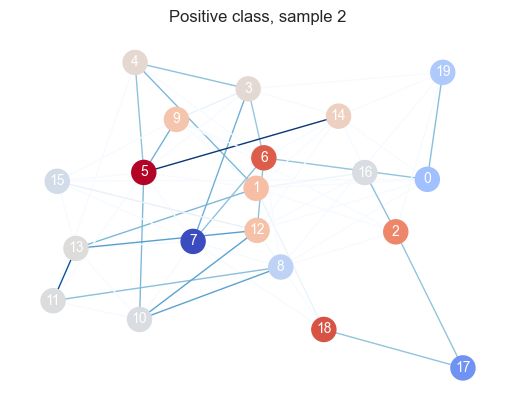

In [40]:
# Visualize one graph and color the nodes according to the feature values
idx = 2

print(f'Graph {idx+1}')
G=nx.from_numpy_array(A[idx])

plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 #pos=nx.circular_layout(G), 
                 pos=nx.spring_layout(G, seed=seed),
                 node_size=300,
                 cmap='coolwarm',
                 font_size=10,
                 font_color='white',
                 node_color=x[idx],
                 edge_color=plt.cm.Blues(A[idx].flatten()),  # Normalized edge colors#A[idx],
                 )
label = 'Positive' if y[idx]==1 else 'Negative'
plt.title(f'{label} class, sample {idx}')

In [14]:
def plot_graphs(x: np.array, y: np.array, num_graphs: int, class_name: str) -> None:
    """
    Plots the first `num_graphs` graphs from the dataset, with each graph's nodes
    colored according to the feature values.
    """
    class_id = 1 if class_name == 'Positive' else 0 # Use value to get indexes of the respective class
    ids = np.where(y==class_id)[0]
    
    num_rows = num_graphs**0.5
    assert num_rows.is_integer(), 'num_graphs should be a square' # for convenience 
    
    fig, axs = plt.subplots(int(num_rows), int(num_rows))
    fig.suptitle(f'{class_name} class')

    for i, idx in enumerate(ids[-num_graphs:]):
        # Plot graph
        if num_graphs == 1: # If we plot one graph only, we have one object
            ix = i
            ax = axs
        else: # else many objects
            ix = np.unravel_index(i, axs.shape)
            ax = axs[ix]
            
        ax.axis('off')
        G = nx.from_numpy_array(A[idx])
        nx.draw_networkx(G,
                        #pos=nx.circular_layout(G), 
                        pos=nx.spring_layout(G, seed=seed),
                        with_labels=True,
                        cmap='coolwarm',
                        node_size=15,
                        font_size=8,
                        node_color=x[idx],
                        ax=ax,
                        width=0.2
                        )
        

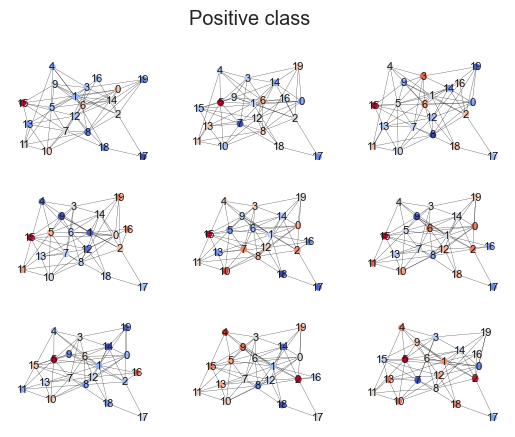

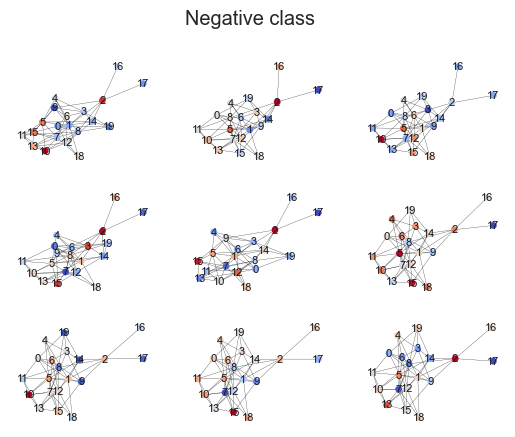

In [15]:
# Plot a few graphs of both classes together
plot_graphs(x, y, 9, 'Positive')
plot_graphs(x, y, 9, 'Negative')

## Data Preprocessing

In [95]:
# Split the data into train, validation, and test sets
id_train, id_test_ = train_test_split(np.arange(len(x)), test_size=0.3, stratify=y, random_state=seed, shuffle=True)
id_val, id_test = train_test_split(np.arange(len(id_test_)), test_size=0.5, stratify=y[id_test_], random_state=seed, shuffle=True)


# Split the data into train, validation, and test sets
def get_mask(idx, length):
    msk = np.zeros(length, dtype=np.bool_)
    msk[idx] = True
    return msk

train_mask = get_mask(id_train, S)
val_mask = get_mask(id_val, S)
test_mask = get_mask(id_test, S)

print(f"Number of samples: Training {id_train.shape[0]} | Validation {id_val.shape[0]} | Testing {id_test.shape[0]}")        

Number of samples: Training 350 | Validation 75 | Testing 75


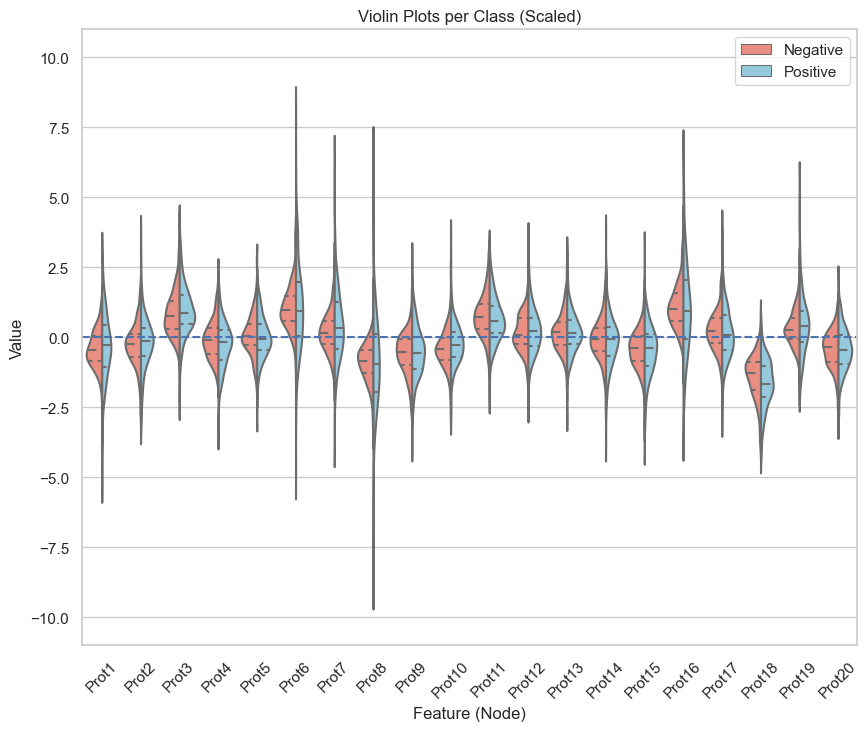

In [13]:
# Train standard scaler on training and validation data, then apply to test data
SCALE_DATA = True # Scale or use raw features

if SCALE_DATA:
    scaler = StandardScaler()
    # train the scaler on training and validation
    scaler.fit(x[(train_mask | val_mask)].reshape(-1, M)) # flatten
    # apply the scaler to the data (prevent information leak to the test data)
    x[train_mask, :, :] = scaler.transform(x[train_mask].reshape(-1, M)).reshape(x[train_mask].shape)
    x[val_mask, :, :] = scaler.transform(x[val_mask].reshape(-1, M)).reshape(x[val_mask].shape)
    x[test_mask, :, :] = scaler.transform(x[test_mask].reshape(-1, M)).reshape(x[test_mask].shape)

    # check the distribution
    data_scaled = np.hstack((x.squeeze(), y))
    
    df = pd.DataFrame(data=data_scaled, columns=list(data.columns[3:]) + [data.columns[2]]) # set the columns in the cirrect order
    df_melted1 = pd.melt(df, id_vars=['class'], 
                        value_vars=[f'Prot{i}' for i in range(1, 21)], 
                        var_name='Protein', value_name='Expression')
                                                                                                                                                                                                                                                                                                                                                                                                    
    sns.set(style="whitegrid")
    palette = {1: 'skyblue', 0: 'salmon'}
    plt.figure(figsize=(10, 8))
    ax = sns.violinplot(x='Protein', y='Expression', hue='class', data=df_melted1, split=True, inner="quart", palette=palette)
    ax.legend(handles=ax.legend_.legendHandles, labels=['Negative', 'Positive'])
    plt.axhline(y=0, color='b', linestyle='--')
    plt.title('Violin Plots per Class (Scaled)')
    plt.xlabel('Feature (Node)')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.ylim([-11, 11])
    plt.show()

## Deep Learning Graph Classification

### MLP
As a baseline model, we can firs us a classic MLP architecture, which completely ignores any topology of the dataset.

In [96]:
from torch.utils.data import Dataset, DataLoader


class Dataset_Tabular(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.reshape((x.shape[0], -1)), dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index,: ], self.y[index]

In [97]:
# Create datasets
train_dataset = Dataset_Tabular(x[train_mask], y[train_mask])
val_dataset   = Dataset_Tabular(x[val_mask], y[val_mask])
test_dataset  = Dataset_Tabular(x[test_mask], y[test_mask])

print(f"Number of samples: Training {len(train_dataset)} | Validation {len(val_dataset)} | Testing {len(test_dataset)}")  

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

Number of samples: Training 350 | Validation 75 | Testing 75


In [98]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [99]:
# Create MLP mode
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, 1)

    def forward(self, x):
        h = self.linear1(x)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.linear2(h)
        return torch.sigmoid(h)

    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)


        self.train()
        for epoch in range(epochs+1):
            train_loss, train_acc = 0.0, 0.0
            # Train on batches
            for x_batch, y_batch in train_loader: 
                optimizer.zero_grad()
                out_train = self(x_batch)
                loss = criterion(out_train, y_batch)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, y_batch) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for x_batch, y_batch in loader:
            out = self(x_batch)
            loss += criterion(out, y_batch) / len(loader)
            acc += accuracy(out>=0.5, y_batch) / len(loader)
        return loss, acc

In [100]:
N_sim = 5
epochs = 120

def test_n_times(model_, train_loader, val_loader, test_loader, epochs, N_sim, verbose=True):
    """Test the model N_times and return the average accuracy."""
    accs = []
    losses = []
    for i in range(N_sim):
    # Create a copy of the model
        model = copy.deepcopy(model_) 
        # Train
        model.fit(train_loader, val_loader, epochs=epochs, verbose=verbose)
        # Test
        loss, acc = model.test(test_loader)
        if verbose:
            print(f'Trial {i+1}, test loss: {loss:.2f} | test accuracy: {acc*100:.2f}%')
        
        # Store the results
        accs.append(acc.detach().detach().cpu().numpy())
        losses.append(loss.detach().detach().cpu().numpy())

    losses, accs = np.array(losses), np.array(accs)
    
    print(f'\nFinal accuracy: {np.mean(accs)*100:.2f}%, std: {np.std(accs)*100:.2f}%')
    print(f'Final loss: {np.mean(losses):.2f}, std: {np.std(losses):.2f}%')

In [102]:
mlp = MLP(dim_in=N*M, dim_h=16).to(device)
print(mlp)
test_n_times(mlp, train_loader, val_loader, test_loader, 300, 1, verbose=True)

MLP(
  (linear1): Linear(in_features=420, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 0.697 | Train Acc: 53.68% | Val Loss: 0.72 | Val Acc: 48.51%
Epoch  20 | Train Loss: 0.671 | Train Acc: 56.88% | Val Loss: 0.67 | Val Acc: 61.36%
Epoch  40 | Train Loss: 0.655 | Train Acc: 66.58% | Val Loss: 0.67 | Val Acc: 57.74%
Epoch  60 | Train Loss: 0.640 | Train Acc: 71.72% | Val Loss: 0.67 | Val Acc: 53.34%
Epoch  80 | Train Loss: 0.619 | Train Acc: 76.25% | Val Loss: 0.65 | Val Acc: 68.54%
Epoch 100 | Train Loss: 0.597 | Train Acc: 78.37% | Val Loss: 0.64 | Val Acc: 67.76%
Epoch 120 | Train Loss: 0.571 | Train Acc: 79.51% | Val Loss: 0.62 | Val Acc: 71.52%
Epoch 140 | Train Loss: 0.552 | Train Acc: 80.00% | Val Loss: 0.62 | Val Acc: 63.99%
Epoch 160 | Train Loss: 0.534 | Train Acc: 79.67% | Val Loss: 0.58 | Val Acc: 74.50%
Epoch 180 | Train Loss: 0.514 | Train Acc: 80.94% | Val Loss: 0.59 | Val Acc: 68.54%
Epoch 200 | Tra

### Prepare a graph dataset

In [103]:
"""Ref: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html#creating-in-memory-datasets"""

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

class DatasetGraph(InMemoryDataset):
    def __init__(self, root, data_list, transform=None):
        self.data_list = data_list
        super().__init__(root, transform)
        self.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    @classmethod
    def save(cls, data_list, path) -> None:
        r"""Saves a list of data objects to the file path :obj:`path`."""
        data, slices = cls.collate(data_list)
        print(data.__class__)
        fs.torch_save((data.to_dict(), slices, data.__class__), path)


    def process(self):
        self.save(self.data_list, self.processed_paths[0])

In [108]:
data_list = []
for idx in range(len(A)):
    edge_index = coo_matrix(A[idx])
    sample = Data(x=torch.tensor(x[idx], dtype=torch.float32).to(device), 
                  edge_index=torch.tensor(np.vstack((edge_index.row, edge_index.col)), dtype=torch.int64).to(device), 
                  edge_weight=torch.tensor(edge_index.data, dtype=torch.float32).to(device), 
                  y=torch.tensor(y[idx], dtype=torch.float32).to(device))
    data_list.append(sample)
    
dataset = DatasetGraph(root='.', data_list=data_list)

## Create training, validation, and test sets
train_dataset = dataset[train_mask]
val_dataset   = dataset[val_mask]
test_dataset  = dataset[test_mask]

assert dataset[0].x.shape[1] == M, print("Delete the dataset")
print(f"Number of samples: Training {len(train_dataset)} | Validation {len(val_dataset)} | Testing {len(test_dataset)}")  

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

Number of samples: Training 350 | Validation 75 | Testing 75


### Vanilla GNN

In [63]:
# TODO 1. Normalize links 2. Try node embeddings 3. Convert data for MLP to pytorch dataset
from torch_geometric.utils import to_dense_adj

class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, edge_index):
        x = self.linear(x)
        adjacency = to_dense_adj(edge_index)[0]
        adjacency += torch.eye(len(adjacency)).to(device) # add self-loop
        x = torch.sparse.mm(adjacency, x)
        return x
    
    
class VanillaGNN(torch.nn.Module):
    # TODO: Include edge_weight
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_h)
        
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.gnn1(x, edge_index)
        h = torch.relu(h)
        h = self.gnn2(h, edge_index)
        h = torch.relu(h)
        
        h = global_add_pool(h, batch)
        
        # Classifier
        h = self.lin1(h)
       
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)

    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)


        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [ ]:
gnn = VanillaGNN(dim_in=M, dim_h=16).to(device)
print(gnn)
test_n_times(gnn, train_loader, val_loader, test_loader, 500, 1, verbose=True)

### GCN

In [109]:
class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_in, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim_in, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index, edge_weight)
        h = h.relu()
        h = self.conv2(h, edge_index, edge_weight)
        h = h.relu()
        
        # Graph-level readout
        h = global_add_pool(h, batch) #global_add_pool, global_max_pool
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)
    
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)


        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [111]:
gcn = GCN(dim_in=M, dim_h=16).to(device) # weights
print(gcn)
test_n_times(gcn, train_loader, val_loader, test_loader, 300, 1, verbose=True)

GCN(
  (conv1): GCNConv(21, 16)
  (conv2): GCNConv(16, 16)
  (lin1): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 0.767 | Train Acc: 47.29% | Val Loss: 0.70 | Val Acc: 51.49%
Epoch  20 | Train Loss: 0.700 | Train Acc: 46.94% | Val Loss: 0.70 | Val Acc: 44.60%
Epoch  40 | Train Loss: 0.688 | Train Acc: 54.50% | Val Loss: 0.68 | Val Acc: 54.62%
Epoch  60 | Train Loss: 0.680 | Train Acc: 57.47% | Val Loss: 0.68 | Val Acc: 59.16%
Epoch  80 | Train Loss: 0.674 | Train Acc: 60.52% | Val Loss: 0.68 | Val Acc: 55.54%
Epoch 100 | Train Loss: 0.662 | Train Acc: 66.84% | Val Loss: 0.66 | Val Acc: 78.27%
Epoch 120 | Train Loss: 0.646 | Train Acc: 73.65% | Val Loss: 0.64 | Val Acc: 76.85%
Epoch 140 | Train Loss: 0.616 | Train Acc: 76.98% | Val Loss: 0.62 | Val Acc: 80.61%
Epoch 160 | Train Loss: 0.581 | Train Acc: 84.79% | Val Loss: 0.57 | Val Acc: 87.64%
Epoch 180 | Train Loss: 0.540 | Train Acc: 86.18% | V

In [73]:
gcn = GCN(dim_in=M, dim_h=16).to(device) # no weights
print(gcn)
test_n_times(gcn, train_loader, val_loader, test_loader, 500, 5, verbose=True)

GCN(
  (conv1): GCNConv(33, 16)
  (conv2): GCNConv(16, 16)
  (lin1): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 0.767 | Train Acc: 48.33% | Val Loss: 0.69 | Val Acc: 55.26%
Epoch  20 | Train Loss: 0.696 | Train Acc: 43.85% | Val Loss: 0.70 | Val Acc: 40.06%
Epoch  40 | Train Loss: 0.689 | Train Acc: 55.87% | Val Loss: 0.69 | Val Acc: 56.82%
Epoch  60 | Train Loss: 0.684 | Train Acc: 56.25% | Val Loss: 0.70 | Val Acc: 47.09%
Epoch  80 | Train Loss: 0.677 | Train Acc: 60.78% | Val Loss: 0.68 | Val Acc: 56.18%
Epoch 100 | Train Loss: 0.667 | Train Acc: 61.86% | Val Loss: 0.66 | Val Acc: 68.25%
Epoch 120 | Train Loss: 0.653 | Train Acc: 63.58% | Val Loss: 0.63 | Val Acc: 73.72%
Epoch 140 | Train Loss: 0.634 | Train Acc: 68.37% | Val Loss: 0.64 | Val Acc: 77.63%
Epoch 160 | Train Loss: 0.604 | Train Acc: 72.67% | Val Loss: 0.59 | Val Acc: 75.43%
Epoch 180 | Train Loss: 0.571 | Train Acc: 75.80% | V

### GraphConv

In [37]:
class GCONV(torch.nn.Module):
    """GraphConv"""
    def __init__(self, dim_in, dim_h):
        super(GCONV, self).__init__()
        self.conv1 = GraphConv(dim_in, dim_h)
        self.conv2 = GraphConv(dim_h, dim_h)

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)#, edge_weight)
        h = h.relu()
        h = self.conv2(h, edge_index)#, edge_weight)
        h = h.relu()
        
        # Graph-level readout
        h = global_add_pool(h, batch) #global_add_pool, global_max_pool
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)
    
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [40]:
gcn = GCN(dim_in=M, dim_h=16).to(device)
print(gcn)
test_n_times(gcn, train_loader, val_loader, test_loader, 500, 1, verbose=True)

GCN(
  (conv1): GCNConv(33, 16)
  (conv2): GCNConv(16, 16)
  (lin1): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 0.694 | Train Acc: 54.76% | Val Loss: 0.69 | Val Acc: 50.07%
Epoch  20 | Train Loss: 0.687 | Train Acc: 54.36% | Val Loss: 0.68 | Val Acc: 58.38%
Epoch  40 | Train Loss: 0.679 | Train Acc: 57.17% | Val Loss: 0.69 | Val Acc: 50.85%
Epoch  60 | Train Loss: 0.674 | Train Acc: 57.59% | Val Loss: 0.68 | Val Acc: 63.71%
Epoch  80 | Train Loss: 0.664 | Train Acc: 58.33% | Val Loss: 0.68 | Val Acc: 47.87%
Epoch 100 | Train Loss: 0.652 | Train Acc: 61.60% | Val Loss: 0.66 | Val Acc: 57.74%
Epoch 120 | Train Loss: 0.643 | Train Acc: 61.49% | Val Loss: 0.66 | Val Acc: 60.72%
Epoch 140 | Train Loss: 0.627 | Train Acc: 63.19% | Val Loss: 0.66 | Val Acc: 53.98%
Epoch 160 | Train Loss: 0.619 | Train Acc: 65.89% | Val Loss: 0.65 | Val Acc: 51.78%
Epoch 180 | Train Loss: 0.580 | Train Acc: 71.63% | V

In [ ]:
class GAT(torch.nn.Module):
    """GAT"""
    def __init__(self, dim_in, dim_h):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=3)
        self.gat2 = GATv2Conv(dim_h*3, dim_h, heads=1)

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.gat1(x, edge_index)#, edge_weight)
        h = h.relu()
        h = self.gat2(h, edge_index)#, edge_weight)
        h = h.relu()
        
        # Graph-level readout
        h = global_add_pool(h, batch) #global_add_pool, global_max_pool
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)
    
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

### GAT

In [ ]:
class GAT(torch.nn.Module):
    """GAT"""
    def __init__(self, dim_in, dim_h):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=3)
        self.gat2 = GATv2Conv(dim_h*3, dim_h, heads=1)

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)
        self.sigmoid = Sigmoid()

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h = self.gat1(x, edge_index)#, edge_weight)
        h = h.relu()
        h = self.gat2(h, edge_index)#, edge_weight)
        h = h.relu()
        
        # Graph-level readout
        h = global_add_pool(h, batch) #global_add_pool, global_max_pool
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return self.sigmoid(h)
    
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)

        self.train()
        
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [ ]:
gat = GAT(dim_in=M, dim_h=16).to(device)
print(gat)
test_n_times(gat, train_loader, val_loader, test_loader, 500, 1, verbose=True)

### GIN

In [ ]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_in, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dim_in, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        #self.conv3 = GINConv(
        #    Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
        #               Linear(dim_h, dim_h), ReLU()))
        
        self.lin1 = Linear(dim_h*2, dim_h*2)#*3
        self.lin2 = Linear(dim_h*2, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        #h3 = self.conv2(h2, edge_index)
        
        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        #h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2), dim=1)
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return torch.sigmoid(h)

    def fit(self, train_loader, val_loader, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001) # weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            train_loss, train_acc = 0.0, 0.0
            
            # Train on batches
            for data in train_loader:
                optimizer.zero_grad()
                out_train = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
                loss = criterion(out_train, data.y)
                
                train_loss += loss / len(train_loader)
                train_acc += accuracy(out_train>=0.5, data.y) / len(train_loader)
                
                loss.backward()
                optimizer.step()

            if(epoch % 20 == 0) and verbose:
                val_loss, val_acc = self.test(val_loader)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc:'
                    f' {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                    f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, loader):
        criterion = torch.nn.BCELoss()
        self.eval()
        loss, acc = 0.0, 0.0
        for data in loader:
            out = self(data.x, data.edge_index, data.edge_weight, data.batch).view(-1)
            loss += criterion(out, data.y) / len(loader)
            acc += accuracy(out>=0.5, data.y) / len(loader)
        return loss, acc

In [ ]:
gin = GIN(dim_in=M, dim_h=16).to(device)
print(gin)
test_n_times(gin, train_loader, val_loader, test_loader, 500, 1, verbose=True)

In [17]:
dim = 32

from tqdm import tqdm
from node2vec import Node2Vec

x_ = torch.concat((torch.tensor(x, dtype=torch.float32), torch.zeros((x.shape[0], x.shape[1], dim), dtype=torch.float32)), dim=-1).to(device)

for i in tqdm(range(A.shape[0])):
    # embedding for each graph
    G = nx.from_numpy_array(A[i])
    node2vec = Node2Vec(G, dimensions=dim, walk_length=20, num_walks=100, p=2, q=1, workers=20, quiet=True)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    x_[i, :, 1:] = torch.tensor(model.wv[np.arange(N)], dtype=torch.float32)
    
    #print(model.wv[np.arange(N)].shape)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [24:34<00:00,  2.95s/it]


Similar outpcomes are found in this **stack overflow** discussion [here](https://stackoverflow.com/questions/75752422/gnn-graph-classification-poor-performance)

In [ ]:
# GraphConv

### Performance comparison

### GNNExplainer and IntegratedGradients

In [ ]:
#from torch_geometric.data import Data
#from torch_geometric.loader import DataLoader
#from scipy.sparse import coo_matrix

#def get_data(dataset, idx):
#    return list(map(dataset.__getitem__, idx))

#dataset = []
#for idx in range(len(A)):
#    edge_index = coo_matrix(A[idx])
#    sample = Data(x=x[idx], edge_index=np.vstack((edge_index.row, edge_index.col)), edge_weight=edge_index.data, y=y[idx])
#    dataset.append(sample)

#train_dataset = get_data(dataset, id_train) 
#val_dataset = get_data(dataset, id_val) 
#test_dataset = get_data(dataset, id_test) 

#print(f"Number of samples: Training {len(train_dataset)} | Validation {len(val_dataset)} | Testing {len(test_dataset)}")   

#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:

# Train standard scaler on training and validation data, then apply to test data
#SCALE_DATA = True # Scale or use raw features

#if SCALE_DATA:
#    scaler = StandardScaler()
#    # train the scaler on training and validation
#    scaler.fit(np.concatenate((x_train, x_val), axis=0).reshape(-1, M)) 
#    # apply the scaler to the data (prevent information leak to the test data)
#    print(x_train[0][0])
#    x_train = scaler.transform(x_train.reshape(-1, M)).reshape(x_train.shape)
#    print(x_train[0][0])
#    x_val = scaler.transform(x_val.reshape(-1, M)).reshape(x_val.shape)
#    X_test = scaler.transform(x_test.reshape(-1, M)).reshape(x_test.shape)

    # check the distribution
#    data_scaled = np.hstack((
#                            np.concatenate((x_train, x_val, x_test), axis=0).squeeze(), 
#                            np.concatenate((y_train, y_val, y_test))
#                            )
#                        )
#    df = pd.DataFrame(data=data_scaled, columns=list(data.columns[3:]) + [data.columns[2]]) # set the columns in the cirrect order
#    df_melted1 = pd.melt(df, id_vars=['class'], 
#                        value_vars=[f'Prot{i}' for i in range(1, 21)], 
#                        var_name='Protein', value_name='Expression')
#                                                                                                                                                                                                                                                                                                                                                                                                    
#    sns.set(style="whitegrid")
#    palette = {1: 'skyblue', 0: 'salmon'}
#    plt.figure(figsize=(10, 8))
#    ax = sns.violinplot(x='Protein', y='Expression', hue='class', data=df_melted1, split=True, inner="quart", palette=palette)
#    ax.legend(handles=ax.legend_.legendHandles, labels=['Negative', 'Positive'])
#    plt.axhline(y=0, color='b', linestyle='--')
#    plt.title('Violin Plots per Class (Scaled)')
#    plt.xlabel('Feature (Node)')
#    plt.ylabel('Value')
#    plt.xticks(rotation=45)
#    plt.ylim([-11, 11])
#    plt.show()

In [ ]:
#N_sim = 20 # number of you simulate to get the average performance
#verbose = True
#res_mlp = []
#for i in range(N_sim):
#    # Create MLP model
#    mlp = MLP(dim_in=N*M, dim_h=16).to(device)
#    if i == 0:
#        print(mlp,'\n')
    
#    # Train
#    mlp.fit(data_mlp, epochs=150, verbose=verbose)
    
#    # Test
#    acc = mlp.test(data_mlp)
#    if verbose:
#        print(f'MLP test accuracy: {acc*100:.2f}%')
    
#    # Store the results
#    res_mlp.append(acc.detach().detach().cpu().numpy())

#res_mlp = np.array(res_mlp)
#print(f'\nMLP final accuracy: {np.mean(res_mlp)*100:.2f}%, std: {np.std(res_mlp)*100:.2f}%')